# Not a Hotdog

Written by Ian McKechnie throughout 2022

## Imports

In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from torchvision.io import read_image
import matplotlib.pyplot as plt
import helper
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler

/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import the image set into a dataloader

In [2]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder('./archive/train/', transform=transform)
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

dataset = datasets.ImageFolder('./archive/test/', transform=transform)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
running_loss = 0.0

## Show a few example images

Not hotdog


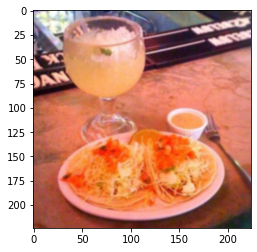

In [3]:
images, labels = next(iter(testLoader))
image = images[0]

if labels[0].long() == 0:
    print("Hotdog")
else:
    print("Not hotdog")

plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic")


## Now to perform the training

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {'train': len(trainLoader.dataset), 'val': len(testLoader.dataset)}

def train_model(Trainloader, testLoader, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        #For the train phase
        phase = 'train'
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in trainLoader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        #Validation phase
        phase = 'val'
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in testLoader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/opt/homebrew/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model_ft = train_model(trainLoader, testLoader, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5825 Acc: 0.6908
val Loss: 0.4696 Acc: 0.8140

Epoch 1/24
----------
train Loss: 0.3630 Acc: 0.8614
val Loss: 0.3368 Acc: 0.8800

Epoch 2/24
----------
train Loss: 0.2079 Acc: 0.9558
val Loss: 0.2978 Acc: 0.8900

Epoch 3/24
----------
train Loss: 0.1353 Acc: 0.9819
val Loss: 0.2770 Acc: 0.8960

Epoch 4/24
----------
train Loss: 0.1258 Acc: 0.9739
val Loss: 0.2732 Acc: 0.8900

Epoch 5/24
----------
train Loss: 0.0628 Acc: 0.9980
val Loss: 0.2560 Acc: 0.8920

Epoch 6/24
----------
train Loss: 0.0444 Acc: 1.0000
val Loss: 0.2453 Acc: 0.8960

Epoch 7/24
----------
train Loss: 0.0411 Acc: 1.0000
val Loss: 0.2469 Acc: 0.8960

Epoch 8/24
----------
train Loss: 0.0304 Acc: 1.0000
val Loss: 0.2456 Acc: 0.8960

Epoch 9/24
----------
train Loss: 0.0384 Acc: 0.9980
val Loss: 0.2452 Acc: 0.8960

Epoch 10/24
----------
train Loss: 0.0319 Acc: 1.0000
val Loss: 0.2457 Acc: 0.8960

Epoch 11/24
----------
train Loss: 0.0312 Acc: 1.0000
val Loss: 0.2451 Acc: 0.9020

Ep

## Showing some example images and their predictions

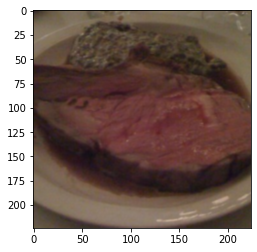

This image is not a hotdog
The image is predicted to be NOT a hotdog
The prediction is correct



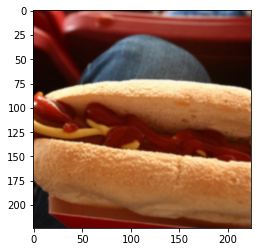

This is an image of a Hotdog
It's predicted to be a hotdog
The prediction is correct



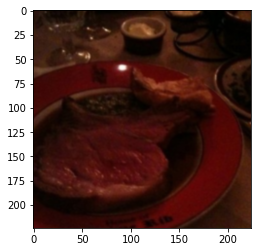

This image is not a hotdog
The image is predicted to be NOT a hotdog
The prediction is correct



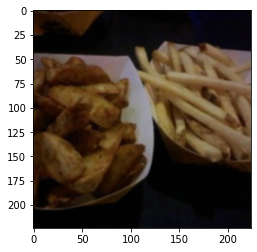

This image is not a hotdog
The image is predicted to be NOT a hotdog
The prediction is correct



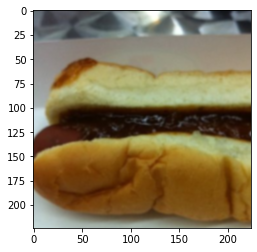

This is an image of a Hotdog
It's predicted to be a hotdog
The prediction is correct



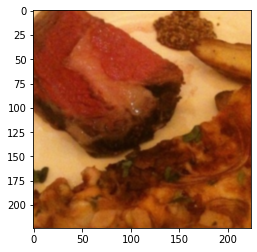

This image is not a hotdog
It's predicted to be a hotdog
The prediction is wrong



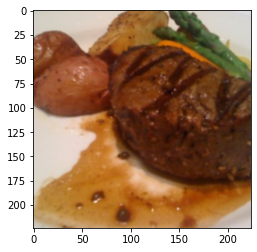

This image is not a hotdog
The image is predicted to be NOT a hotdog
The prediction is correct



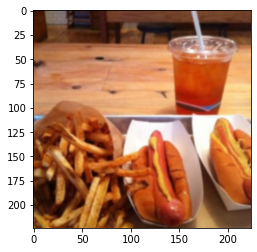

This is an image of a Hotdog
It's predicted to be a hotdog
The prediction is correct



In [7]:
images, labels = next(iter(testLoader))

for i in range(8):
    image = images[i]
    label = labels[i]   
    plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic")
    plt.show()

    if labels[i].long().item() == 0:
        print("This is an image of a Hotdog")
    else:
        print("This image is not a hotdog")

    outputs = model_ft(image.unsqueeze(0).to(device))
    _, preds = torch.max(outputs, 1)
    if preds[0].long() == 0:
        print("It's predicted to be a hotdog")
    else:
        print("The image is predicted to be NOT a hotdog")

    if labels[i].long().item() == preds[0].long():
        print("The prediction is correct")
    else:
        print("The prediction is wrong")
    print()